In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from random import random, randrange



knn = KNeighborsClassifier(n_neighbors = 15)
linreg = LogisticRegression(C=100,solver="newton-cg")
gnb = GaussianNB(priors=None,var_smoothing=1e-09)
adb = AdaBoostClassifier(n_estimators=100,learning_rate=1.0,algorithm='SAMME')
et = ExtraTreesClassifier(n_estimators=100,criterion="gini",min_samples_split=2)
rf= RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_split=2)
xgbr = xgb.XGBClassifier(learning_rate=0.05,n_estimators=100, max_depth = 5,eta = .05,objective="binary:logistic")


In [2]:
X_train = np.load('./X_train_G.npy')
y_train = np.load('./y_train_G.npy')
X_test = np.load('./X_test_G.npy')
y_test = np.load('./y_test_G.npy')
X_val = np.load('./X_val_G.npy')
y_val = np.load('./y_val_G.npy')

In [3]:
features = np.load('./feature_r.npy')
featureB = np.load('./bwofeatures.npy')

X_trainr = X_train[:, features]
X_testr = X_test[:, features]
X_valr = X_val[:, features]

X_trainb = X_train[:, featureB==1]
X_testb = X_test[:, featureB==1]
X_valb = X_val[:, featureB==1]

In [8]:
rf.fit(X_trainb,y_train)

RandomForestClassifier()

In [9]:
rf.score(X_testb,y_test)

0.977382892703681

In [13]:
adb.fit(X_trainb,y_train)
adb.score(X_testb,y_test)

0.9676989183582753

In [4]:
knn.fit(X_trainb,y_train)

In [5]:
knn.score(X_testb,y_test)

0.9723133585928074

In [6]:
linreg.fit(X_trasinb,y_train)
linreg.score(X_testb,y_test)

0.9693605401858476

In [4]:
rf_yhat, lr_yhat,adb_yhat,gnb_yhat, knn_yhat, xgb_yhat, et_yhat = [], [], [], [], [], [], []

In [5]:
models_dict = { 'RF' : [rf,rf_yhat],
                'ET':[et,et_yhat],
                'KNN':[knn,knn_yhat]
               }

In [6]:
from sklearn.model_selection import KFold
def train_oof_predictions(x, y, models, verbose=True):

    # instantiate a KFold with 10 splits
    kfold = KFold(n_splits=10, shuffle=True,random_state=10)

    # prepare lists to hold the re-ordered x and y values
    data_x, data_y  = [], []

    # run the following block for each of the 10 kfold splits
    for train_ix, test_ix in kfold.split(x, y):

        #if verbose: print("\nStarting a new fold\n")

        #if verbose: print("Creating splits")
        #create this fold's training and test sets
        train_X, test_X = x[train_ix].copy(), x[test_ix].copy()
        train_y, test_y = y[train_ix].copy(), y[test_ix].copy()

        #if verbose: print("Adding x and y to lists\n")
        # add the data that is used in this fold to the re-ordered lists
        data_x.extend(test_X)
        data_y.extend(test_y)

        # run each model on this kfold and add the predictors to the model's running predictors list
        for item in models:

            label = item # get label for reporting purposes
            model = models[item][0] # get the model to use on the kfold

            # fit and make predictions
            #if verbose: print("Running",label,"on this fold")
            model.fit(train_X, train_y) # fit to the train set for the kfold
            predictions = model.predict(test_X) # fit on the out-of-fold set
            models[item][1].extend(predictions) # add predictions to the model's running predictors list

    return data_x, data_y, models


In [7]:
data_x, data_y, trained_models = train_oof_predictions(X_trainb, y_train, models_dict)

In [8]:
def create_meta_dataset(data_x, items):
    '''Function that takes in a data set and list of predictions, and forges into one dataset
    parameters:
    data_x - original data set
    items - list of predictions
    returns: stacked data set
    '''

    meta_x = data_x.copy()

    for z in items:
        z = np.array(z).reshape((len(z), 1))
        meta_x = np.hstack((meta_x, z))

    return meta_x

In [9]:
def stack_prediction(X, final_models):
    '''takes in a test set and a list of fitted models.
    Fits each model in the list on the test set and stores it in a predictions list. Then sends the test set and the predictions to the create_meta_dataset to be combined
    Returns: combined meta test set
    Parameters:
    X_test - testing dataset
    final_models - list of fitted models
    '''
    predictions = []

    for item in final_models:
        #print(item)
        
        preds = item.predict(X).reshape(-1,1)
        predictions.append(preds)

    meta_X = create_meta_dataset(X, predictions)

    return meta_X

In [10]:
knn1 = KNeighborsClassifier(n_neighbors = 15)
linreg1 = LogisticRegression(C=100,solver="newton-cg")
gnb1 = GaussianNB(priors=None,var_smoothing=1e-09)
adb1 = AdaBoostClassifier(n_estimators=100,learning_rate=1.0,algorithm='SAMME')
et1 = ExtraTreesClassifier(n_estimators=100,criterion="gini",min_samples_split=2)
rf1= RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_split=2)
xgbr1 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=100, max_depth = 5,eta = .05,objective="binary:logistic")

In [11]:
rf_yhat1, lr_yhat1,adb_yhat1,gnb_yhat1, knn_yhat1, xgb_yhat1, et_yhat1 = [], [], [], [], [], [], []

In [12]:
tr = { 'RF' : [rf1,rf_yhat1],
       'ET':[et1,et_yhat1],
       'KNN':[knn1,knn_yhat1]
}

In [13]:
for i in tr:
    tr[i][0].fit(X_trainb,y_train)

In [14]:
def func(model,X,y_train,label,inc):
    current = X_valb.copy()
    if len(inc)>0:
        d = []
        for i in inc:
            d.append(tr[i][0])
        current = stack_prediction(X_valb,d)
    
    model.fit(X,y_train)
    y_pred = model.predict(current)
    return f1_score(y_val,y_pred,average='macro')

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss
def model_selector(X, y, meta_model, models_dict, model_label, verbose=True):

    """
    Perform a forward model selection based on MAE improvement
    Parameters:
        X - baseline X_train with all features
        y - baseline y_train with all targets
        meta_model - meta_model to be trained
        models_dict - dictionary of models in format of model name : [model object, out-of-fold predictions]
        label - the label for the current meta model
        verbose - whether to print the sequence of inclusions(True recommended)
    Returns: list of selected models, best MAE
    """
    print("\n\nRunning model selector for ", model_label)
    included_models = []

    while True:
        changed=False

        # forward step

        if verbose: print("\nNEW ROUND - Setting up score charts")
        excluded_models = list(set(models_dict.keys())-set(included_models)) # make a list of the current excluded_models
        if verbose: print("Included models: {}".format(included_models))
        if verbose: print("Exluded models: {}".format(excluded_models))
        new_mae = pd.Series(index=excluded_models) # make a series where the index is the current excluded_models

        current_meta_x = np.array(X)

        if len(included_models) > 0:
            for included in included_models:
                included = np.array(models_dict[included][1]).reshape((len(models_dict[included][1]), 1))
                current_meta_x = np.hstack((current_meta_x, included))
# score the current model
        scores = func(meta_model, current_meta_x, y,model_label,included_models)
        starting_mae = scores
        if verbose: print("Starting mae: {}\n".format(starting_mae))


        for excluded in excluded_models:  # for each item in the excluded_models list:

            new_yhat = np.array(models_dict[excluded][1]).reshape(-1, 1) # get the current item's predictions
            meta_x = np.hstack((current_meta_x, new_yhat)) # add the predictions to the meta set
            inc = included_models.copy()
            inc.append(excluded)
            # score the current item
            scores = func(meta_model, meta_x, y,model_label,inc)
            mae = scores
            if verbose: print("{} score: {}".format(excluded, mae))

            new_mae[excluded] = mae # append the mae to the series field

        best_mae = new_mae.max() # evaluate best mae of the excluded_models in this round
        if verbose: print("Best mae: {}\n".format(best_mae))

        if best_mae > starting_mae:  # if the best mae is better than the initial mae
            best_feature = new_mae.idxmax()  # define this as the new best feature
            included_models.append(str(best_feature)) # append this model name to the included list
            changed=True # flag that we changed it
            if verbose: print('Add  {} with mae {}\n'.format(best_feature, best_mae))
        else: changed = False

        if not changed:
            break

    print(model_label, "model optimized")
    print('resulting models:', included_models)
    print('MAE:', starting_mae)

    return included_models, starting_mae

In [ ]:
scores = {}
scores['Model'] = []
scores['MAE'] = []
scores['Included'] = []
# Run the model stack selector for each model in our trained_models
for model in trained_models:

    meta_model = trained_models[model][0]
    resulting_models, best_mae = model_selector(data_x, data_y,  meta_model, trained_models, model, verbose=True)

    scores['Model'].append(model)
    scores['MAE'].append(best_mae)
    scores['Included'].append(resulting_models)

In [18]:
best_model = pd.DataFrame(scores).reset_index(drop=True)
best_model.sort_values('MAE', ascending=False)

,Model,MAE,Included
5,ET,0.818970,"[RF, ET, KNN]"
3,RF,0.817558,"[ET, RF, Logistic Regression, XGB, KNN, GNB]"
4,XGB,0.815272,"[ET, RF]"
2,ADB,0.800701,[ET]
1,Logistic Regression,0.799106,"[ET, RF, Logistic Regression]"
6,KNN,0.720683,"[ET, RF, XGB, Logistic Regression]"
0,GNB,0.512049,"[RF, ET, KNN, XGB, Logistic Regression, ADB]"


In [15]:
yhat_predics1 = [trained_models['RF'][1],trained_models['ET'][1],trained_models['KNN'][1]]
meta_X_train1 = create_meta_dataset(data_x, yhat_predics1)

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, precision_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def fit(X):
    final_models1 = [tr['RF'][0],tr['ET'][0],tr['KNN'][0]]
    meta_X_test1 = stack_prediction(X,final_models1)
    et2 = ExtraTreesClassifier(n_estimators=100,criterion="gini",min_samples_split=2)
    et2.fit(meta_X_train1,data_y)
    y_pred = et2.predict(meta_X_test1)
    return y_pred

In [17]:
y_predt = fit(X_testb)

In [20]:
print(confusion_matrix(y_test,y_predt))

[[90907   151]
 [ 1830  1598]]


In [21]:
print(confusion_matrix(y_val,y_predv))

[[22773    35]
 [  417   397]]


In [23]:
print(classification_report(y_val,y_predv))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22808
           1       0.92      0.49      0.64       814

    accuracy                           0.98     23622
   macro avg       0.95      0.74      0.81     23622
weighted avg       0.98      0.98      0.98     23622



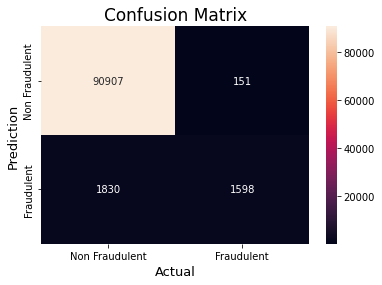

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_predt)

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Non Fraudulent','Fraudulent'],
            yticklabels=['Non Fraudulent','Fraudulent'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.savefig('./Conf.pdf', format='pdf')
plt.show()

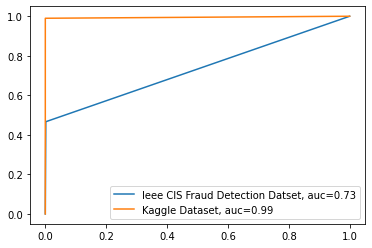

In [3]:
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(0).clf()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predt)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test1,y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_predt)
roc_auc1 = metrics.roc_auc_score(y_test1, y_pred)
plt.plot(fpr,tpr,label="Ieee CIS Fraud Detection Datset, auc="+str(round(roc_auc,2)))
plt.plot(fpr1,tpr1,label="Kaggle Dataset, auc="+str(round(roc_auc1,2)))
plt.legend()
plt.savefig('./AUC_comp.pdf',format = 'pdf')
plt.show()

In [2]:
import numpy as np
y_pred = np.load('./y_pred_t.npy')
y_test1 = np.load('./y_test_G1.npy')
y_predt = np.load('./y_predt.npy')
y_test = np.load('./y_test_G.npy')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Fitness = np.load('./ScoreR.npy')
Y = []
for i in range(len(Fitness)):
  Y.append(i+1)
plt.plot(Y[::-1],Fitness, color = 'Blue')
plt.scatter(Y[::-1],Fitness,color = 'Blue')
plt.title('Feature Selection Using RFESVC')
plt.xlabel('No. of Features Selected')
plt.ylabel('Accuracy')
plt.savefig('./rfe.pdf',bbox_inches = 'tight')
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from random import random, randrange



svc = SVC(gamma = 0.1, kernel = 'rbf',C=10)
knn = KNeighborsClassifier(n_neighbors = 15)
linreg = LogisticRegression(C=100,solver="newton-cg")
gnb = GaussianNB(priors=None,var_smoothing=1e-09)
adb = AdaBoostClassifier(n_estimators=100,learning_rate=1.0,algorithm='SAMME.R')
et = ExtraTreesClassifier(n_estimators=100,criterion="gini",min_samples_split=2)
rf= RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_split=2)
xgbr = xgb.XGBClassifier(learning_rate=0.05,n_estimators=100, max_depth = 5,eta = .05,objective="binary:logistic")
# Define a classifier model (you can use any model you like)
classifier = Sequential()
classifier.add(Dense(24, input_dim=X_trainr.shape[1], activation='relu'))
#classifier.add(Dropout(0.2))
classifier.add(Dense(12, activation='relu'))
#classifier.add(Dropout(0.2))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

svc1 = SVC(gamma = 0.1, kernel = 'rbf',C=10)
knn1 = KNeighborsClassifier(n_neighbors = 15)
linreg1 = LogisticRegression(C=100,solver="newton-cg")
gnb1 = GaussianNB(priors=None,var_smoothing=1e-09)
adb1 = AdaBoostClassifier(n_estimators=100,learning_rate=1.0,algorithm='SAMME.R')
et1 = ExtraTreesClassifier(n_estimators=100,criterion="gini",min_samples_split=2)
rf1= RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_split=2)
xgbr1 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=100, max_depth = 5,eta = .05,objective="binary:logistic")
# Define a classifier model (you can use any model you like)
classifier1 = Sequential()
classifier1.add(Dense(24, input_dim=X_trainb.shape[1], activation='relu'))
#classifier.add(Dropout(0.2))
classifier1.add(Dense(12, activation='relu'))
#classifier1.add(Dropout(0.2))
classifier1.add(Dense(1, activation='sigmoid'))
classifier1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
tr = { 'RF' : [rf],
       'GNB' : [gnb],
       'Logistic Regression' : [linreg],
       'ADB' : [adb],
       'MLP' : [classifier],
       'ET' : [et],
       'XGB' : [xgbr]
    }
tr1 = { 'RF' : [rf1],
       'GNB' : [gnb1],
       'Logistic Regression' : [linreg1],
       'ADB' : [adb1],
       'MLP' : [classifier1],
       'ET' : [et1],
       'XGB' : [xgbr1]
    }

In [11]:
for i in tr:
    if i=='MLP':
        tr[i][0].fit(X_trainr,y_train,epochs = 10, batch_size = 64)
    else:
        tr[i][0].fit(X_trainr,y_train)
for i in tr1:
    if i=='MLP':
        tr1[i][0].fit(X_trainb,y_train,epochs = 10, batch_size = 64)
    else:
        tr1[i][0].fit(X_trainb,y_train)

c:\Users\Prasoon Jha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Epoch 1/10


7398/7398 [==============================] - 37s 5ms/step - loss: 0.1471 - accuracy: 0.9645
Epoch 2/10
7398/7398 [==============================] - 33s 4ms/step - loss: 0.1349 - accuracy: 0.9672
Epoch 3/10
7398/7398 [==============================] - 33s 4ms/step - loss: 0.1344 - accuracy: 0.9673
Epoch 4/10
7398/7398 [==============================] - 33s 4ms/step - loss: 0.1342 - accuracy: 0.9674
Epoch 5/10
7398/7398 [==============================] - 34s 5ms/step - loss: 0.1341 - accuracy: 0.9673
Epoch 6/10
7398/7398 [==============================] - 35s 5ms/step - loss: 0.1340 - accuracy: 0.9674
Epoch 7/10
7398/7398 [==============================] - 33s 4ms/step - loss: 0.1339 - accuracy: 0.9674
Epoch 8/10
7398/7398 [==============================] - 34s 5ms/step - loss: 0.1339 - accuracy: 0.9674
Epoch 9/10
7398/7398 [==============================] - 56s 8ms/step - loss: 0.1338 - accuracy: 0.9674
Epoch 10/10
7398/7398 [==============================] - 66s 9ms/step -

c:\Users\Prasoon Jha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Epoch 1/10
7398/7398 [==============================] - 56s 7ms/step - loss: 0.1161 - accuracy: 0.9685
Epoch 2/10
7398/7398 [==============================] - 35s 5ms/step - loss: 0.1049 - accuracy: 0.9725
Epoch 3/10
7398/7398 [==============================] - 35s 5ms/step - loss: 0.1019 - accuracy: 0.9731
Epoch 4/10
7398/7398 [==============================] - 36s 5ms/step - loss: 0.1000 - accuracy: 0.9735
Epoch 5/10
7398/7398 [==============================] - 35s 5ms/step - loss: 0.0984 - accuracy: 0.9739
Epoch 6/10
7398/7398 [==============================] - 36s 5ms/step - loss: 0.0970 - accuracy: 0.9742
Epoch 7/10
7398/7398 [==============================] - 36s 5ms/step - loss: 0.0960 - accuracy: 0.9745
Epoch 8/10
7398/7398 [==============================] - 36s 5ms/step - loss: 0.0951 - accuracy: 0.9748
Epoch 9/10
7398/7398 [==============================] - 35s 5ms/step - loss: 0.0944 - accuracy: 0.9750
Epoch 10/10
7398/7398 [==============================] - 33s 4ms/step - l

In [20]:
r = []
l = []
ad = []
gn = []
ml = []
e = []
xg = []

In [21]:
for i in tr:
    if i=='MLP':
        y_pred = tr[i][0].predict(X_testr)
        classes_x = (y_pred > 0.5).astype("int32")
        ml.append(precision_score(y_test,classes_x))
    else:
        y_pred = tr[i][0].predict(X_testr)
        sc = precision_score(y_test,y_pred)
        if i=='ET':
            e.append(sc)
        elif i=='RF':
            r.append(sc)
        elif i=='Logistic Regression':
            l.append(sc)
        elif i=='ADB':
            ad.append(sc)
        elif i=='GNB':
            gn.append(sc)
        elif i=='XGB':
            xg.append(sc)
for i in tr1:
    if i=='MLP':
        y_pred = tr1[i][0].predict(X_testb)
        classes_x = (y_pred > 0.5).astype("int32")
        ml.append(precision_score(y_test,classes_x))
    else:
        y_pred = tr1[i][0].predict(X_testb)
        sc = precision_score(y_test,y_pred)
        if i=='ET':
            e.append(sc)
        elif i=='RF':
            r.append(sc)
        elif i=='Logistic Regression':
            l.append(sc)
        elif i=='ADB':
            ad.append(sc)
        elif i=='GNB':
            gn.append(sc)
        elif i=='XGB':
            xg.append(sc)

2953/2953 [==============================] - 6s 2ms/step


In [22]:
# Generate dummy data into a dataframe
j = {
    'RF': r,
    'LR': l,
    'ADB': ad,
    'GNB': gn,
    'MLP': ml,
    'ET':e,
    'XGB':xg
}
df = pd.DataFrame(j)

In [15]:
df

,RF,LR,ADB,GNB,MLP,ET,XGB
0,0.096849,0.049883,0.063594,0.085764,0.063011,0.096849,0.097725
1,0.408401,0.202450,0.240957,0.794924,0.334014,0.432030,0.245333


In [19]:
df

,RF,LR,ADB,GNB,MLP,ET,XGB
0,0.965815,0.964799,0.965614,0.963741,0.965593,0.965815,0.965815
1,0.977362,0.969361,0.970112,0.503556,0.973340,0.977499,0.971551


In [23]:
df

,RF,LR,ADB,GNB,MLP,ET,XGB
0,0.712446,0.712500,0.848249,0.501706,0.847059,0.712446,0.709746
1,0.926539,0.811696,0.788168,0.055693,0.829109,0.892169,0.892781
